# IMDB

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
from fastai import *
from fastai.text import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled between positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [3]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb_sample/texts.csv')]

In [9]:
URLs.IMDB_SAMPLE

'http://files.fast.ai/data/examples/imdb_sample'

It only contains one csv file, let's have a look at it.

In [10]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


In [12]:
df['text'][0]

"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!"

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set. If we ignore this flag, we can create a DataBunch containing this data in one line of code:

In [13]:
data_lm = TextDataBunch.from_csv(path, 'texts.csv')

By executing this line a process was launched that took a bit of time. Let's dig a bit into it. Images could be fed (almost) directly into a model because they're just a big array of pixel values that are floats between 0 and 1. A text is composed of words, and we can't apply mathematical functions to them directly. We first have to convert them to numbers. This is done in two differents steps: tokenization and numericalization. A `TextDataBunch` does all of that behind the scenes for you.

Before we delve into the explanations, let's take the time to save the things that were calculated.

In [14]:
data_lm.save()

Next time we launch this notebook, we can skip the cell above that took a bit of time (and that will take a lot more when you get to the full dataset) and load those results like this:

In [15]:
data = TextDataBunch.load(path)

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

In [19]:
data = TextClasDataBunch.load(path)
data.show_batch()

text,label
"xxfld 1 raising victor vargas : a review \n\n you know , raising victor vargas is like sticking your hands into a big , xxunk bowl of xxunk . it 's warm and gooey , but you 're not sure if it feels right . try as i might , no matter how warm and gooey raising victor vargas became i was always aware that something did n't quite feel right . victor vargas suffers from a certain xxunk on the director 's part . apparently , the director thought that the ethnic backdrop of a latino family on the",negative
"xxfld 1 now that che(2008 ) has finished its relatively short australian cinema run ( extremely limited xxunk screen in xxunk , after xxunk ) , i can xxunk join both xxunk of "" at the movies "" in taking steven soderbergh to task . \n\n it 's usually satisfying to watch a film director change his style / subject , but soderbergh 's most recent stinker , the girlfriend xxunk ) , was also missing a story , so narrative ( and editing ? ) seem to suddenly be soderbergh 's main challenge . strange , after xxunk years",negative
"xxfld 1 many xxunk that this is n't just a classic due to the fact that it 's the first 3d game , or even the first xxunk - up . it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . with graphics that are terribly dated today , the game xxunk you into the role of xxunk even * think * i 'm going to attempt spelling his last name ! ) , an american",positive
"xxfld 1 i really wanted to love this show . i truly , honestly did . \n\n for the first time , gay viewers get their own version of the "" the bachelor "" . with the help of his obligatory "" hag "" xxunk , james , a good looking , well - to - do thirty - something has the chance of love with 15 suitors ( or "" mates "" as they are referred to in the show ) . the only problem is half of them are straight and james does n't know this . if",negative
"xxfld 1 this film sat on my xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of new xxunk . \n\n the format is the same as max xxunk ' "" la xxunk , "" based on a play by arthur xxunk , who is given an "" inspired by "" credit . it starts from one person , a prostitute , standing on a street xxunk in brooklyn . she is picked",positive
"xxfld 1 how viewers react to this new "" adaption "" of shirley jackson 's book , which was promoted as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one ... and those who have never been exposed to either , and who are big fans of hollywood 's current trend towards "" special effects "" being the first and last word",negative
"xxfld 1 to review this movie , i without any doubt would have to quote that memorable scene in tarantino 's "" pulp fiction "" ( xxunk ) when jules and vincent are talking about mia wallace and what she does for a living . jules tells vincent that the "" only thing she did worthwhile was pilot "" . vincent asks "" what the hell is a pilot ? "" and jules goes into a very well description of what a tv pilot is : "" well , the way they make shows is , they make one show",negative
"xxfld 1 \n\n i 'm sure things did n't exactly go the same way in the real life of homer hickam as they did in the film adaptation of his book , rocket boys , but the movie "" october sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read hickam 's memoirs , but i am still able to enjoy and understand their film adaptation . the film , directed by joe xxunk and written by lewis xxunk , xxunk the story of teenager homer hickam (",positive
"xxfld 1 well , what can i say . \n\n "" what the xxunk do we know "" has achieved the nearly impossibl

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabular size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

In [20]:
data.vocab.itos[:10]

['xxunk', 'xxpad', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']

And if we look at what a what's in our datasets, we'll see only numbers:

In [21]:
data.train_ds[0][0][:10]

[43, 40, 34, 170, 61, 6, 350, 3, 46, 1492]

In [37]:
data.train_ds[2][1]

0

### With the data block API

We can use the data block API with NLP and have a lot more flexibility thant what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [38]:
data = (TextSplitData.from_csv(path, 'texts.csv', input_cols=1, label_cols=0, valid_col=2)
        .datasets(TextDataset)
        .tokenize() #can specify custom arguments for tokenization here
        .numericalize() #can specify custom arguments for numericalization here
        .databunch(TextDataBunch))

Now let's grab the full dataset for what follows.

In [39]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train')]

In [40]:
(path/'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsup')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [41]:
data_lm = (TextFileList.from_folder(path)         
           #grab all the text files in path
           .label_const(0)           
           #label them all wiht 0s (the targets aren't positive vs negative review here)
           .split_by_folder(valid='test')         
           #split by folder between train and validation set
           .datasets() 
           #use `TextDataset`, the flag `is_fnames=True` indicates to read the content of the files passed
           .tokenize()
           #tokenize with defaults from fastai
           .numericalize()
           #numericalize with defaults from fastai
           .databunch(TextLMDataBunch))
           #use a TextLMDataBunch

data_lm.save('tmp_lm')

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

## Start here if re-running

In [5]:
path = Path('/home/jupyter/.fastai/data/imdb/')

In [6]:
path

PosixPath('/home/jupyter/.fastai/data/imdb')

In [7]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm')
data_lm.show_batch()

idx,text
0,"xxfld 1 avenging eagle is the story of a man chi ming - sing ( ti lung ) who after years of killing for a brutal gang decides to leave and seek revenge against them and their leader . the gang , know as the iron boat clan and in particular the men he raided with the 13 eagles . all were raised from birth by yoh xi - hung ( ku feng ) to be brutal killers to obey his every command . each with his own hand made eagle medallion and weapon ."
1,"to be there ) . the son sees them together laughing and jumps to conclusions . he promptly leaves not telling his father what he 's seen . but , nothing ever happened ! but the son , played by an actor i do n't know , goes ballistic . \n\n the only problem i have is that the actor seems to get a little over - the - top . but , then again it is his strong reaction which is the catapult of all that happens later in the film . \n\n what"
2,"school in edinburgh . apparently they did n't bother waiting until the people died in order to make a few pounds -- often suffocating their hapless victims ! ! \n\n years later , in 1960 , another variation of the william burke and william hare story came to the theaters , but this one ( starring peter cushing ) was not based on the stevenson novel but the actual crimes . while the lewton movie was marvelous and horrifying , this one seems worth seeing as well because it is more realistic and unflinching ("
3,"you wo n't be able to redeem your one - and - a - half hours by just listening to the soundtrack . it 's crap too . all of the dramatic tension is relieved after forty minutes , which means that the film wanders aimlessly and pointlessly for another forty . omar sharif 's commentary on the xxup dvd is similarly inane . there is really nothing to be said in favour of this movie along any dimension . xxfld 1 i do n't want to write a comment for this useless and completely"
4,"have been great . in the middle of a dramatic film , these shots just feel like padding with bad acting . \n\n the story itself , although relatively simple -- too simple , perhaps , is chopped up and told as if it 's going to have some big revelation or twist . altman keeps unnecessarily jumping back and forth in time -- but just a few hours , and he keeps unnecessarily jumping back and forth between different sets of characters in the middle of ( very ) long scenes . i guess"
5,", thinner man ( the stunt guy is actually wearing fake fat to look like steven ) , who has a lot more physical talent than steven had in his prime . this is further compounded by the fact that the stunt man performs stunts that steven could never perform ( jump kicks , jump spin kick , and all other stunts involving jumping high ) . \n\n the movie seems to have been filmed entirely in bangkok , thailand and recruited what seems to be the entire cast of xxunk bak , minus tony"
6,"can & will do much better . \n\n i was n't expecting a block buster here but come on some crappy low budget film could at least try harder . the effects were so overly cheap its not funny . xxfld 1 years have past since alex rain ( played by olivier gruner in the first movie ) stumbled onto the horrific plot that involved replacing humans with machines however since then a war between cyborgs and humans has emerged and we lost , now a superwoman of sorts who is the daughter of olivier"
7,"for and about her ! i have a hard time understanding xxup why she agreed to do this film because it hits so close to home . in other words , the title character is pretty much the real joan crawford . both were extreme xxunk , very controlling , emotionally constricted and could not ( or claimed they could not in the case of harriet craig ) have kids . and , of course , both had serious problems having a normal intimate relationship with those around them . while the biographies i have"
8,"and laura . all said and done , this is a lousy picture and i purchased the xxup dvd for only $ 1.50 and i really got ripped xxup off ! xxfld 1 bad

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [8]:
# bptt default is 75 but ran out of memory using default
learn = language_model_learner(data_lm, drop_mult=0.3, pretrained_model=URLs.WT103, bptt=60)

In [8]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


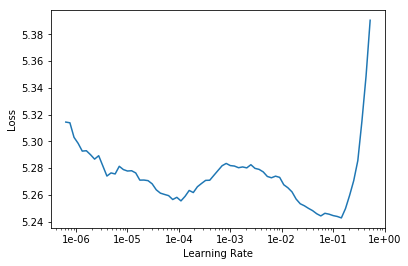

In [46]:
learn.recorder.plot(skip_end=15)

In [47]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 18:05
epoch  train_loss  valid_loss  accuracy
1      4.593635    4.445621    0.250231  (18:05)



In [48]:
learn.save('fit_head')

In [9]:
learn.load('fit_head')

LanguageLearner(data=<fastai.text.data.TextLMDataBunch object at 0x7f4828445d68>, model=SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60002, bias=True)
    (output_dp): RNNDropout()
  )
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=<function cross_entropy at 0x7f47b93cec80>, metrics=[<function accuracy at 0x7f47b2972c80>], true_wd=True, bn_wd=True, wd=0.01, train_bn=True,

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [10]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

Total time: 19:43
epoch  train_loss  valid_loss  accuracy
1      4.279771    4.219566    0.275002  (19:43)



In [12]:
learn.save('fine_tuned')

In [13]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

Total time: 19:41
epoch  train_loss  valid_loss  accuracy
1      4.196813    4.166374    0.281702  (19:41)



In [16]:
learn.predict('my')

Total time: 00:00



'my own'

In [17]:
learn.save('fine_tuned-2')

In [18]:
learn.fit_one_cycle(1, 1e-3, moms=(0.8,0.7))

Total time: 19:39
epoch  train_loss  valid_loss  accuracy
1      4.165388    4.134218    0.285746  (19:39)



We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
data_clas = (TextFileList.from_folder(path)
             #grap all the text files in path
            .label_from_folder(classes=['neg','pos'])
             #label them all with their folder, only keep 'neg' and 'pos'
            .split_by_folder(valid='test')
             #split by folder between train and validation set
            .datasets()
             #use `TextDataset`, the flag `is_fnames=True` indicates to read the content of the files passed
            .tokenize()
             #tokenize with defaults from fastai
            .numericalize(vocab = data_lm.vocab)
             #numericalize with the same vocabulary as our pretrained model
            .databunch(TextClasDataBunch, bs=50))
data_clas.save('tmp_clas')

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=50)
data_clas.show_batch()

text,label
"xxfld 1 match 1 : tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit . according to the rules of the match , both opponents have to go through tables in order to get the win . benoit and guerrero heated up early on by taking turns hammering first spike and then bubba ray . a german suplex by benoit to bubba took the wind out of the dudley brother . spike tried to",pos
"xxfld 1 i wo n't try to speculate as to what brando was attempting . at his best he turns in such oddball performances , insinuating so many things at once , that it does n't seem he does anything so much as play by unfailing instinct . often it seems he is calling attention to some favored aspect of his character over all others , a concentration which , if followed , turns out something of a red herring , as he turns out subtler , craftier than at first appeared . this is a mastery of artifice ,",pos
"xxfld 1 this was the second of two filmed "" hamlets "" in the nineties , the first being franco zeffirelli 's , starring mel gibson , from 1990 . zeffirelli 's version , like laurence olivier 's from 1948 , was based upon an abridged version of the play , with much of shakespeare 's original text being cut . ( i have never seen tony richardson 's 1969 version , but as that ran to less than two hours , shorter even than zeffirelli 's , i presume that was also abridged ) . kenneth branagh was attempting",pos
"xxfld 1 it 's always difficult to put a stamp on any film as being ' the best , ' whether of all time , a certain genre , or what have you , but i believe a strong argument could be made that in fact , laputa is the greatest animated film ever made . it is in my mind the masterwork of hayao miyazaki , the most talented of japan 's animated directors , and it best captures his strengths as a director , storyteller , and designer , as well as encapsulating all of his favorite underlying",pos
"xxfld 1 when i first popped in happy birthday to me , i checked the timer to see how long the film was . i was amazed at the length . both animated and horror films share a common ground : attention span of the selected audience and that should be at or right around 90 minutes . anything more , and you 'll lose the bulk of your audience . \n\n this 110 minutes , or 20 minutes past its prime was a huge problem for me . i 'd like to say half of this movie could 've",neg
"xxfld 1 linking story : another first - time viewing for me and , again , this is one of the most popular of the amicus anthologies - and it 's easy to see why , though i realize how the film 's rather meaningless title could be misleading for some ; i certainly fancied director peter duffell 's choice - xxup death xxup and xxup the xxup maiden ( which , incidentally , is a classical piece by schubert that is heard in the film during the peter cushing episode ) - a great deal more . though the",pos
"xxfld 1 this comment does contain spoilers ! ! \n\n there are few actors that have an intangible to them . that innate quality which is an amalgamation of charisma , panache and swagger . it 's the quality that can separate good actors from the truly great . i think george clooney has it and so does jack nicholson . you can look at clooney 's subtle touches in scenes like his one word good - bye to andy garcia in ocean 's 11 when they just utter each other 's name xxunk . "" terry . "" """,pos
"xxfld 1 was this a comedy or was it a drama ? i begin this review by asking this question because the film that i just witnessed , hollywood shuffle , was neither funny or rather dramatic . while it tried so hard to make a point , because of this lack of definition ( comedy or drama ) , the clever themes and pointed remarks were lost . while i am a strong believer that there is too much racial profiling happening in hollywood , even today , i do not believe that towns

We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 02:40
epoch  train_loss  valid_loss  accuracy
1      0.281750    0.209883    0.917120  (02:40)



In [ ]:
learn.save('first')

In [ ]:
learn.load('first')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7efb33525dd8>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 02:57
epoch  train_loss  valid_loss  accuracy
1      0.234253    0.186893    0.929160  (02:57)



In [ ]:
learn.save('second')

In [ ]:
learn.load('second')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7efb33525dd8>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 04:02
epoch  train_loss  valid_loss  accuracy
1      0.218634    0.157757    0.941840  (04:02)



In [11]:
learn.save('third')

In [ ]:
learn.load('third')

TextClassifierLearner(data=<fastai.text.data.TextClasDataBunch object at 0x7efb33525dd8>, model=SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60002, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60002, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 09:52
epoch  train_loss  valid_loss  accuracy
1      0.180064    0.151520    0.944040  (04:55)
2      0.142421    0.155700    0.944120  (04:56)

